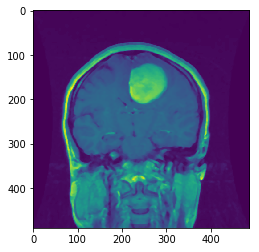

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage import measure

#read image
image = cv2.imread('H:/FYP/interim/images/222.jpg',0)

#preprocess using median blur
img = cv2.medianBlur(image,5)

plt.imshow(img)

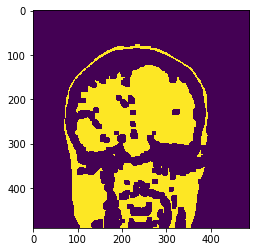

In [83]:
#erosion using morphological operations

ret,th1 = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(th1, kernel, iterations = 4)
plt.imshow(erosion)

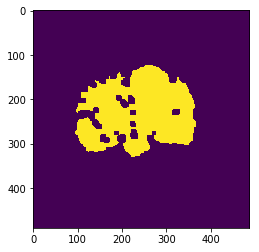

In [84]:
# perform a connected component analysis on the eroded image, then initialize a mask to store only the "large" components

labels = measure.label(erosion, neighbors=8, background=0)
mask1 = np.zeros(erosion.shape, dtype="uint8")
 
# loop over the unique components
for label in np.unique(labels):
	# if this is the background label, ignore it
	if label == 0:
		continue
 
	# otherwise, construct the label mask and count the
	# number of pixels 
	labelMask = np.zeros(erosion.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
 
	# if the number of pixels in the component is sufficiently
	# large, then add it to our mask of "large blobs"
	if numPixels > 30000:
		mask1 = cv2.add(mask1, labelMask)
        
plt.imshow(mask1)

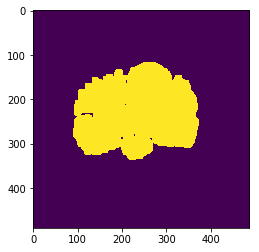

In [85]:
mask = cv2.dilate(mask1,kernel,iterations = 6)
plt.imshow(mask)

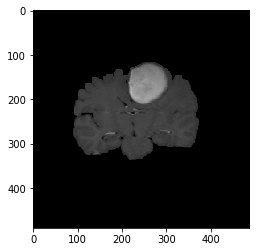

In [86]:
#extract the brain using the mask
img = io.imread("H:/FYP/interim/images/222.jpg")
mask2 = np.where((mask<200),0,1).astype('uint8')

brain_img = img*mask2[:,:,np.newaxis]

plt.imshow(brain_img)

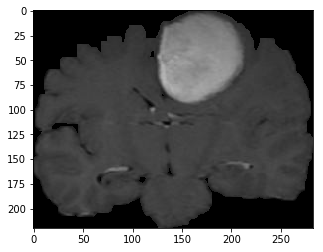

In [87]:
# Load image, grayscale, Otsu's threshold, and extract ROI
image = brain_img
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
x,y,w,h = cv2.boundingRect(thresh)
ROI = image[y:y+h, x:x+w]
plt.imshow(ROI)

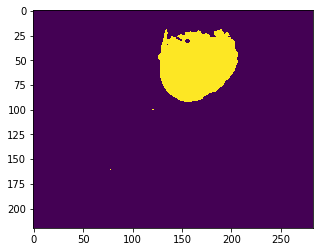

In [88]:
# Color segmentation on ROI
hsv = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)
lower = np.array([0, 0, 125])
upper = np.array([179, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
plt.imshow(mask)

In [89]:
# Crop left and right half of mask
x, y, w, h = 0, 0, ROI.shape[1]//2, ROI.shape[0]
left = mask[y:y+h, x:x+w]
right = mask[y:y+h, x+w:x+w+w]

# Count pixels
left_pixels = cv2.countNonZero(left)
right_pixels = cv2.countNonZero(right)

# Crop top and bottom half of mask
x, y, w, h = 0, 0, ROI.shape[1], ROI.shape[0]//2
bottom = mask[y+h:y+h+h, x:x+w]
top = mask[y:y+h, x:x+w]

# Count pixels
top_pixels = cv2.countNonZero(top)
bottom_pixels = cv2.countNonZero(bottom)

distance =  60.53924347066124


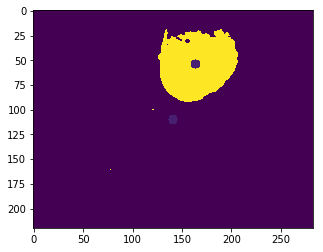

In [90]:
# convert the grayscale image to binary image
ret,thresh = cv2.threshold(mask,127,255,0)
 
# calculate moments of binary image
M = cv2.moments(thresh)
 
# calculate x,y coordinate of center of tumor
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# calculate x,y coordinate of center of image
iX = ROI.shape[1]//2
iY = ROI.shape[0]//2

# put text and highlight the center
center = cv2.circle(mask, (cX, cY), 5, (22, 100, 8), -1)
#center = cv2.putText(center, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (22, 100, 8), 2)
 
center = cv2.circle(center, (iX, iY), 5, (22, 100, 8), -1)
#center = cv2.putText(center, "centroid", (iX - 25, iY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (22, 100, 8), 2)
 
import math
p1 = [iX, iY]
p2 = [cX, cY]
distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )

# display the image
plt.imshow(center)

print('distance = ', distance)

In [91]:
x_len = ROI.shape[1]
y_len = ROI.shape[0]

rX = cX
rY = y_len - cY

kX = ((rX/x_len)*200) - 100
kY = ((rY/y_len)*200) - 100
print('tumor location:(',kX,',' ,kY, ')')

if left_pixels > right_pixels:
    print("  Left")
else:
    print("  Right")
    
if top_pixels > bottom_pixels:
    print("  Top")
else:
    print("  Bottom")

tumor location:( 15.901060070671377 , 50.90909090909091 )
  Right
  Top
